cell 1 buat import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import joblib
import glob
import seaborn as sns

cell 2, disini buat nge apply greyscale ama segmentasiin pake ostu

In [2]:
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return blur

def segment(img_blur):

    _, thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return closed

cell 3 baut extract bentuk dari hasil segmentasi sebelumnyha pake hu_momoents, warna pake hsv, ama texture pake glcm, berdasarkan yang udah kita buat di paper

In [3]:
def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    resized = cv2.resize(img, (200, 200))
    blur = preprocess(resized)
    mask = segment(blur)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    c = max(contours, key=cv2.contourArea)

    moments = cv2.moments(c)
    hu_moments = cv2.HuMoments(moments).flatten()

    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    mean_color = cv2.mean(hsv)[:3]

    glcm = graycomatrix(blur, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return np.concatenate([hu_moments, mean_color, [contrast, homogeneity]])

cell 4 buat training, dataset di seimbangkan dengan emnyamakan semua jumlah image setiap kelas yang ada dengan kelas yg paling dikit

In [4]:
def load_dataset(folder):
    df = pd.read_csv(os.path.join(folder, '_classes.csv'))
    data_per_class = defaultdict(list)

    for _, row in df.iterrows():
        path = os.path.join(folder, row['filename'])
        feats = extract_features(path)
        if feats is not None:
            label_col = row.index[1:]
            label_val = row.iloc[1:]
            label = label_col[label_val == 1].values[0]
            data_per_class[label].append((feats, label))

    min_samples = min(len(v) for v in data_per_class.values())

    X, y = [], []
    for samples in data_per_class.values():
        selected = samples[:min_samples]
        for feat, label in selected:
            X.append(feat)
            y.append(label)

    return np.array(X), np.array(y)


X_train, y_train = load_dataset("train")
X_valid, y_valid = load_dataset("valid")
X_test, y_test = load_dataset("test")

import collections
print(collections.Counter(y_train))

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Counter({'Robusta': 402, 'Arabika': 402, 'Liberika': 402})
Train: (1206, 12) Valid: (153, 12) Test: (153, 12)


cell 5

In [5]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, class_weight='balanced'))
clf.fit(X_train, y_train_enc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', probability=True))])

cell 6 buat nampilin hasil training nya

In [6]:
y_test_enc = le.transform(y_test)
y_pred_enc = clf.predict(X_test)

print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))

              precision    recall  f1-score   support

     Arabika       0.86      0.63      0.73        51
    Liberika       0.85      0.65      0.73        51
     Robusta       0.55      0.82      0.66        51

    accuracy                           0.70       153
   macro avg       0.75      0.70      0.71       153
weighted avg       0.75      0.70      0.71       153



cell 7 save hasil model ama labelnya pake formatnya pkl biar gampang

In [7]:
joblib.dump(clf, "coffee_classifier.pkl")
joblib.dump(le, "label_encoder.pkl")
print("model n label selesai disave.")

model n label selesai disave.


cell 8 buat testing, testingnya udah di pisahin dan di taro di 3 folder "randomtest*", keluarkan salah satu gambar ke root untuk nge test gambar tersebut

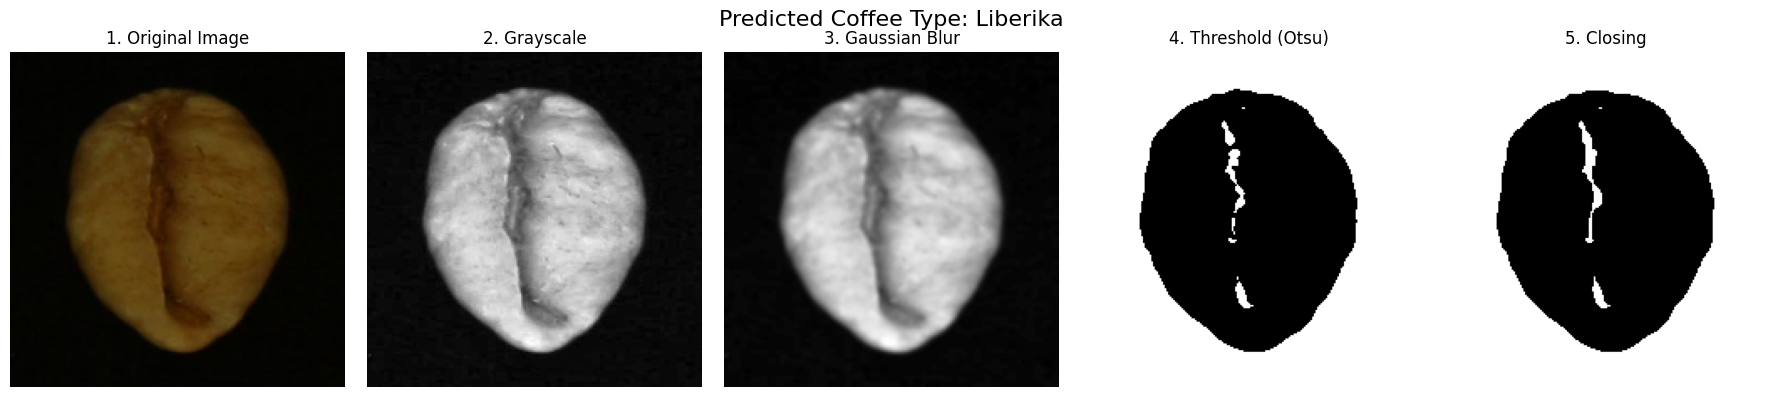

In [8]:
clf = joblib.load("coffee_classifier.pkl")
le = joblib.load("label_encoder.pkl")

def predict_single_image(image_path, clf, le):
    img = cv2.imread(image_path)
    if img is None:
        print("Gagal membaca gambar.")
        return

    resized = cv2.resize(img, (200, 200))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    feats = extract_features(image_path)
    if feats is None:
        print("Gagal ekstrak fitur, coba gambar lain.")
        return

    feats = feats.reshape(1, -1)
    pred_enc = clf.predict(feats)
    pred_label = le.inverse_transform(pred_enc)[0]

    # Tampilkan lima tahapan
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    plt.title("1. Original Image")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("2. Grayscale")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(blur, cmap='gray')
    plt.title("3. Gaussian Blur")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(thresh, cmap='gray')
    plt.title("4. Threshold (Otsu)")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(morph, cmap='gray')
    plt.title("5. Closing")
    plt.axis('off')

    plt.suptitle(f"Predicted Coffee Type: {pred_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

image_paths = glob.glob("coba*.jpg")
if image_paths:
    predict_single_image(image_paths[0], clf, le)
else:
    print("Tidak ditemukan gambar yang cocok dengan pola 'coba*.jpg'")

cell 9 buat ngecheck tabel evaluasinya

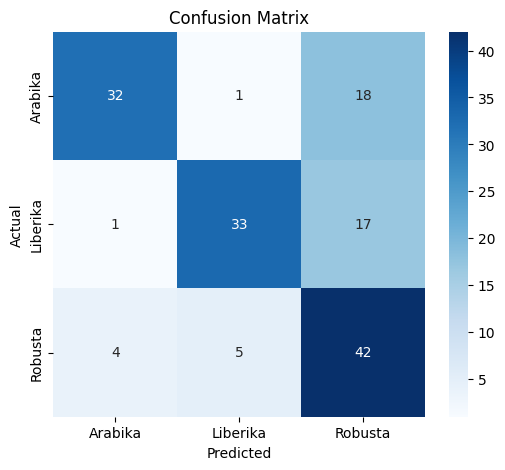

      Class  TP  FP  FN  TN
0   Arabika  32   5  19  97
1  Liberika  33   6  18  96
2   Robusta  42  35   9  67


In [9]:
clf = joblib.load("coffee_classifier.pkl")
le = joblib.load("label_encoder.pkl")

y_test_enc = le.transform(y_test)

y_pred_enc = clf.predict(X_test)

cm = confusion_matrix(y_test_enc, y_pred_enc)
labels = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

confusion_table = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    confusion_table.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })

df_confusion = pd.DataFrame(confusion_table)
print(df_confusion)
